forked from main iowa_redistricting on march 28

manually implementing algorithm described in Chen and Rodden (2013)

Shapefile dataframes used in this notebook

shapefile_iowa: MGGG stuff merged with census stuff

shapef_ia_proj: projected to UTM so we can run distance calculations on it

shapef_ia_fordistricting: 99 rows for each county, ready for initial allocation; made from deep copy of shapef_ia_proj

shapef_counties_for_realloc: made from a deep copy from shapef_ia_fordistricting; this has a num_switches column and a district column populated with the district assignment from the initial allocation

shapef_ia_initialdistricting: came from _fordistricting, went through the districting (step 1/2) process, and is now 4 rows
	as of Sept 18, not modified further for step 3/district balancing

shapef_ia_redist: this is a deep copy of shapef_ia_initialdistricting with a few dropped columns. This df is used for making new districts

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 


import math         ##for math.sqrt
import random       #for random selection of district to start with

# Prepping the census and geopandas dataframes

## Importing data

In [2]:
#census.csv is data from Secretary of State's office.
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [3]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 57 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   99 non-null     object  
 1   COUNTYFP10  99 non-null     object  
 2   GEOID10     99 non-null     int64   
 3   NAME10      99 non-null     object  
 4   NAMELSAD10  99 non-null     object  
 5   ALAND10     99 non-null     int64   
 6   AWATER10    99 non-null     int64   
 7   INTPTLAT10  99 non-null     object  
 8   INTPTLON10  99 non-null     object  
 9   TOTPOP      99 non-null     int64   
 10  NH_WHITE    99 non-null     int64   
 11  NH_BLACK    99 non-null     int64   
 12  NH_AMIN     99 non-null     int64   
 13  NH_ASIAN    99 non-null     int64   
 14  NH_NHPI     99 non-null     int64   
 15  NH_OTHER    99 non-null     int64   
 16  NH_2MORE    99 non-null     int64   
 17  HISP        99 non-null     int64   
 18  H_WHITE     99 non-null     int64   
 19  H_

In [4]:
## Merging ONLY 2020 population numbers and county_id from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population','county_id']], on='COUNTYFP10').copy()

In [5]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4

## Projecting shapefile to UTM 15N

In [6]:
#First, show the current coordinate reference system
shapefile_iowa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [7]:
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

shapef_ia_proj.crs

<Derived Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 96°W and 90°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Arkansas; Illinois; Iowa; Kansas; Louisiana; Michigan; Minnesota; Mississippi; Missouri; Nebraska; Oklahoma; Tennessee; Texas; Wisconsin.
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
#checking out geopandas automatic distance calculation
shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid

0.0

## Merging pd and gpd dataframes and creating population heat map

In [9]:
## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population and county_id are already there)
map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude']], on='COUNTYFP10').copy()

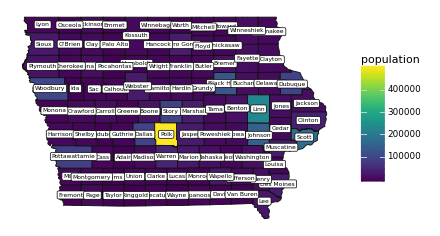

<ggplot: (378574098)>

In [10]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

# Creating distance matrix for Iowa counties

In [11]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y
#shapef_ia_proj.info()
# shapef_ia_proj['xcentr_lon'].iloc[1]

In [12]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data
#      and (later on): also removing ALAND and AWATER, since they just get messy with merges and dissolves

districting_columns = ['COUNTYFP10', 'NAME10', 'geometry', 
       'population', 'county_id', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_fordistricting = shapef_ia_proj[districting_columns].copy()

#add column of county indices (which will get concatenated, as county_id_string)
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id']
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id_string'].astype(str).str.pad(2,fillchar='0')

#add column of county indices (which will become district indices)
shapef_ia_fordistricting['temp_district'] = shapef_ia_fordistricting.index

shapef_ia_fordistricting.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   COUNTYFP10        99 non-null     object  
 1   NAME10            99 non-null     object  
 2   geometry          99 non-null     geometry
 3   population        99 non-null     int64   
 4   county_id         99 non-null     int64   
 5   xcentr_lon        99 non-null     float64 
 6   ycentr_lat        99 non-null     float64 
 7   county_id_string  99 non-null     object  
 8   temp_district     99 non-null     int64   
dtypes: float64(2), geometry(1), int64(3), object(3)
memory usage: 7.7+ KB


# Nearest-Neighbor district-building model

* To start, we have 99 districts, 1 for each county.
* Randomly select a district (single county at the moment!) to start with.
* Join it to its nearest neighbor (using centroid measurement of distance).
    * Make new shapefile with those two counties dissolved together (and calc new centroids/distances)
    * Now we have 98 districts. Repeat until 4 left.

This procedure preserves compactness well, but has no population controls.
After we're down to 4 districts, we will then swap counties between districts until populations stabilize.


## Building-block functions (adjacency matrix + distance matrix)

In [13]:
# function for arbitrary adjacency matrix

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersects(temp_shapefile.iloc[[i]].unary_union)
    
    adjac_mat = adjac_mat - np.identity(curr_n_districts)
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


In [14]:
#function: input is a shapefile with centroid columns, output is a distance matrix
def temp_distance_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    distance_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(i):      #just do half the triangle, so indices from 0 to i-1
            x_dist = (temp_shapefile['xcentr_lon'].iloc[i] - temp_shapefile['xcentr_lon'].iloc[j])
            y_dist = (temp_shapefile['ycentr_lat'].iloc[i] - temp_shapefile['ycentr_lat'].iloc[j])
            distance_mat[i,j] = math.sqrt(x_dist**2 + y_dist**2)
            distance_mat[j,i] = math.sqrt(x_dist**2 + y_dist**2)

    return distance_mat


## full step 1/2 algorithm with iterability

In [15]:
shapef_ia_initialdistricting = shapef_ia_fordistricting.copy()


random.seed(2)      #for initial replicability while building.
#                    #if seed = 2, then this starts with the county with 7, Boone County.
        #first runthrough: 7 selected, 36 neighbor (merged is labeled as 7)
        #second runthrough: 11 selected, 33 is neighbor (merged is labeled as 11)

for i in range(95): ##### 95 iterations brings us from 99 districts to 4
    #how many districts are we working with this time?
    running_ndistricts = len(shapef_ia_initialdistricting)

    # pick out a district to work on on this iteration of the loop
    running_index = random.randint(0,running_ndistricts-1)        

    #find the temp_district associated with the running index
    #     the below was returning a slice of a dataframe, and not just the entry
    # running_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == running_index, 'temp_district']
    running_temp_district = shapef_ia_initialdistricting['temp_district'].iloc[running_index]
    #     originally just called this for the print statement
         

    #set up adjacency and distance matrices
    running_adjmat = adj_mat_calc(shapef_ia_initialdistricting)
    running_distmat = temp_distance_matrix(shapef_ia_initialdistricting)

    print("On loop # %d (with %d districts remaining), we have selected index %d. \
    \n This corresponds to county id %s and temporary district # %d."   \
        % (i+1, running_ndistricts,running_index,   \
           shapef_ia_initialdistricting['county_id_string'].iloc[running_index], \
           running_temp_district) )
    
    #------find closest neighbor: could use cleaning up/making better
    distance_list = list(running_distmat[running_index])
    # distance_list.index(0)      # the index of the element with value 0 is 7

    # sorting is inefficient, maybe fix
    # https://stackoverflow.com/questions/26779618/python-find-second-smallest-number

    neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor (since distance to self is zero)
    ##                                                    ### OR! check on adjacency matrix first!
    neighbor_index = distance_list.index(neighbor_dist)     #county 36 (Greene) is closest to county 7 (Boone)
    
    # the temp_district number associated with the neighbor_index
    # the below was having iiiiissues
    #     neighbor_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index ==neighbor_index, 'temp_district']
    neighbor_temp_district= shapef_ia_initialdistricting['temp_district'].iloc[neighbor_index]
    #   this doesn't really get used except to print? but running_temp_district is super important for re-indexing

    print("The nearest neighbor index is %d, representing county id %s and temporary district # %d." \
        % (neighbor_index,   \
           shapef_ia_initialdistricting['county_id_string'].iloc[neighbor_index],\
           neighbor_temp_district) )
    #---------end finding closest neightbor

    # re-index the neighbor county to be in the first county's district
    shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == neighbor_index, 'temp_district'] = running_temp_district      


    # dissolve shapefile based on temp_district to combine the two counties
    #aggregate remaining columns by summing them

    # arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.dissolve(
        by="temp_district",
        aggfunc = {
            "COUNTYFP10": "sum",    #sum = concatenation here b/c string
            "NAME10": "count",      #kind of dummy: will be 2 only for most-recently-merged district
            "population": "sum",
            "county_id": "sum",     #should be actual sum here, kind of dummy
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            "county_id_string": "sum", #sum = concatenation here b/c string
            "temp_district": "first"
        }
    )

    # update centroid lat/longs!
    shapef_ia_initialdistricting['xcentr_lon'] = shapef_ia_initialdistricting.centroid.x
    shapef_ia_initialdistricting['ycentr_lat'] = shapef_ia_initialdistricting.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.reset_index(drop=True)


    print("Districts remaining:", len(shapef_ia_initialdistricting))  #print how many districts are left

# shapef_ia_initialdistricting = shapef_ia_initialdistricting.copy()


On loop # 1 (with 99 districts remaining), we have selected index 7.     
 This corresponds to county id 07 and temporary district # 7.
The nearest neighbor index is 36, representing county id 36 and temporary district # 36.
Districts remaining: 98
On loop # 2 (with 98 districts remaining), we have selected index 11.     
 This corresponds to county id 11 and temporary district # 11.
The nearest neighbor index is 33, representing county id 33 and temporary district # 33.
Districts remaining: 97
On loop # 3 (with 97 districts remaining), we have selected index 10.     
 This corresponds to county id 10 and temporary district # 10.
The nearest neighbor index is 20, representing county id 20 and temporary district # 20.
Districts remaining: 96
On loop # 4 (with 96 districts remaining), we have selected index 46.     
 This corresponds to county id 49 and temporary district # 49.
The nearest neighbor index is 60, representing county id 63 and temporary district # 63.
Districts remaining: 9

In [16]:
# these were used to check which counties (via IDs and FIPs) were in each district
# list(shapef_ia_initialdistricting["county_id_string"])
# list(shapef_ia_initialdistricting["COUNTYFP10"])

### plot maps of new districts

In [17]:
shapef_ia_initialdistricting['combined_label'] = shapef_ia_initialdistricting['population'].astype(str)  + str(' (dist ') + shapef_ia_initialdistricting['temp_district'].astype(str) + str (')')
shapef_ia_initialdistricting['combined_label']
# shapef_ia_initialdistricting.info()

0     133122 (dist 42)
1     412348 (dist 61)
2     385133 (dist 74)
3    2259766 (dist 94)
Name: combined_label, dtype: object

### functions that draw maps

In [18]:
#label_field: 'population', 'temp_district', 'combined_label'
def map_merged_districts(new_shapefile,label_field):
    map_population_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=(label_field),size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_population_by_district

#input: shapefile of counties within a particular district 
#   (after undergoing identity overlay)
#   label_field options: 'NAME10', 'population_2', 'county_id', 'county_id_string_2', etc
def map_unmerged_districts(new_shapefile,label_field):
    map_counties_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population_2'))
        + geom_label(aes(x='xcentr_lon_2', y='ycentr_lat_2', 
                        label=label_field,size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )

    return map_counties_by_district

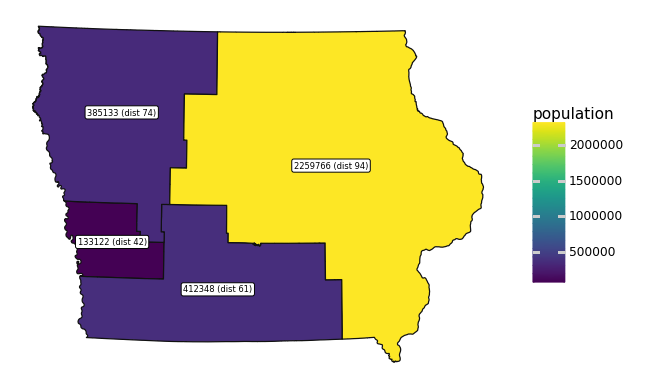

<ggplot: (376034133)>

In [19]:
map_merged_districts(shapef_ia_initialdistricting,'combined_label')

In [20]:
shapef_ia_initialdistricting[['population','temp_district']]

,population,temp_district
0,133122,42
1,412348,61
2,385133,74
3,2259766,94


# Begin step 3: redistributing counties until population is within bounds

## Helper Functions

In [21]:
# helper function: input is a shapefile with 'population' 
# column. output is a full matrix with SIGNED
# population differences between attributes
# row - col
# positive value in row i column j means that pop(i) > pop(j)
# negative value in row i column j means that pop(i) < pop(j)
def pop_diff_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    pop_diff_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(curr_n_districts):   
            pop_diff_mat[i,j] = temp_shapefile['population'].iloc[i] - temp_shapefile['population'].iloc[j]
    
    return pop_diff_mat


## helper function: given a dataframe of movable counties
# and another dataframe of the district they're going to
# make a list of relative distances
def calculate_rel_dist(border_counties,new_district):
    n_border_counties = len(border_counties)
    distance_list = np.zeros((n_border_counties,3))

    for i in range(n_border_counties):
        oldx_dist = border_counties['xcentr_lon_2'].iloc[i] - border_counties['xcentr_lon_1'].iloc[i]
        oldy_dist = border_counties['ycentr_lat_2'].iloc[i] - border_counties['ycentr_lat_1'].iloc[i]

        # old_dist
        distance_list[i,0] = math.sqrt(oldx_dist**2 + oldy_dist**2)

        newx_dist = border_counties['xcentr_lon_2'].iloc[i] - new_district['xcentr_lon'].iloc[0]
        newy_dist = border_counties['ycentr_lat_2'].iloc[i] - new_district['ycentr_lat'].iloc[0]

        # new_dist
        distance_list[i,1] = math.sqrt(newx_dist**2 + newy_dist**2)

        ## relative_distance: old - new
        # we'll move the county with highest relative distance
        distance_list[i,2] = distance_list[i,0] - distance_list[i,1]

    #we only need relative distances, not the component parts
    #so we could just make an n x 1 list instead of n x 3
    rel_dist = distance_list[:,2]
    return rel_dist

In [22]:
#-----------module to find neighboring districts with the greatest population difference---------------------
def neighbor_popdiff_fun(df):
    #adjacencey matrix for 4 districts
    adj_mat_array = adj_mat_calc(df).to_numpy()   

    #SIGNED population difference array
    # row minus col
    # positive value in row i column j means that pop(i) > pop(j)
    # negative value in row i column j means that pop(i) < pop(j)
    pop_diff_array = pop_diff_matrix(df)
    # zero out any pairs that aren't adjacent
    # for numpy arrays, "*" is piecewise multiplication
    neighbor_popdiff = adj_mat_array * pop_diff_array

    return neighbor_popdiff

In [78]:
#Identify the border counties between the two districts with biggest population difference
#return a dataframe with the border counties with a column of relative distances between the big and small districts
def border_counties_fun(shapef_ia_redist, list_of_districts, list_of_counties):
    neighbor_popdiff=neighbor_popdiff_fun(shapef_ia_redist)
    #maxpopdiff_loc is an ordered pair giving the location of the
    #maximum value within neighbor_popdiff. Note!! Indexed on (0,n-1)!
    maxpopdiff_loc = np.unravel_index(np.argmax(neighbor_popdiff, axis=None),   neighbor_popdiff.shape)

    #population threshold for a border county that can get moved:
    #  half of the difference between the two neighboring districts we're adjusting
    #  if dist 1 has pop 700k and dist 2 has pop 1mil, then max size that can be moved
    #  from dist 2 to dist 1 is 300k
    pop_limit_switch=.7*neighbor_popdiff.max()

    #big district is the *row*, so first element of ordered pair
    big_dist_index = maxpopdiff_loc[0]
    #small district is the *column*, so second element of ordered pair
    small_dist_index = maxpopdiff_loc[1]

    # big district geodataframe
    # should match shapef_ia_redist.iloc[[big_dist_index]]
    #    (though with diff indexing, which matters in distance helper fxn)
    # bigdist = list_of_districts[big_dist_index].copy()
    smalldist = list_of_districts[small_dist_index].copy()

    #----------find which county will be swapped from "bigdist" to  "smalldist"----------------------
    #from the list of 4 dataframes (each of diff districts)
    #we call the dataframe of the big district
    bigdist_counties = list_of_counties[big_dist_index].copy()

    #dataframe of counties in the Big district which are 
    #adjacent to the Small district so which we might move
    #(possible to be point neighbors and have issues -
    #should be okay with D criterion, though)
    #reset index so it is (0,n-1), instead of sparse indexing based on where the county     was within the district
    #we retain the original county id in 'county_id'
    bigdist_movable = bigdist_counties.loc[bigdist_counties.intersects(smalldist.unary_union)].reset_index(drop=True).copy()

    # adding column to bigdist_movable with relative distances
    bigdist_movable['rel_distance'] = calculate_rel_dist(bigdist_movable,smalldist)
    return bigdist_movable, pop_limit_switch, small_dist_index

- border counties function:
    - compute population differences between pairwise adjacent districts (done)
    - In descending order of population differences, create a border counties dataframe
        - for each border county dataframe, compute pop_limit_switch and small_dist_index
        - output border county dataframe along with its pop_limit_switch and small_dist_index as a 3-tuple???

- switch function
    - sort each dataframe of border counties in descending order of relative distance
    - start for loop for j in range(number of border county dataframes) and run through process currently in the function
        - add "else" statement: if there are no good counties to move in the jth border county dataframe, proceed to j+1th dataframe

In [106]:
#Modify border_counties_fun to return a list of dataframes with their respective pop_limit_switch and small_dist_index
#reworking here so as to not screw up original function

#Identify the border counties between the two districts with biggest population difference
#return a dataframe with the border counties with a column of relative distances between the big and small districts
def border_counties_df_func(shapef_ia_redist, list_of_districts, list_of_counties):
    neighbor_popdiff=neighbor_popdiff_fun(shapef_ia_redist)
    #popdiff_locs is a list of ordered pairs giving the location of the
    #positive values within neighbor_popdiff corresponding to adjacent districts. Note!! Indexed on (0,n-1)!
    popdiff_locs=np.argwhere(neighbor_popdiff>0)
    # maxpopdiff_loc = np.unravel_index(np.argmax(neighbor_popdiff, axis=None),   neighbor_popdiff.shape)

    big_dist_list=[]
    small_dist_list=[]
    pop_limit_switch_list=[]
    
    for i in range(popdiff_locs.shape[0]):
        big_dist_index=popdiff_locs[i][0]
        big_dist_list.append(big_dist_index)
        small_dist_index=popdiff_locs[i][1]
        small_dist_list.append(small_dist_index)
        pop_limit_switch=.7*neighbor_popdiff[big_dist_index][small_dist_index]
        pop_limit_switch_list.append(pop_limit_switch)

    df=pd.DataFrame()
    df['big_dist_index']=big_dist_list
    df['small_dist_index']=small_dist_list
    df['pop_limit_switch']=pop_limit_switch_list

    df=df.sort_values('pop_limit_switch', ascending=False).reset_index(drop=True)
    #Note: pop_limit_switch is a proxy for actual pop limits and we can sort off of this list. But we need to make sure other lists are sorted accordingly


    #----------find which county will be swapped from "bigdist" to  "smalldist"----------------------
    #from the list of 4 dataframes (each of diff districts)
    #we call the dataframe of the big district

        #dataframe of counties in the Big district which are 
    #adjacent to the Small district so which we might move
    #(possible to be point neighbors and have issues -
    #should be okay with D criterion, though)
    #reset index so it is (0,n-1), instead of sparse indexing based on where the county     was within the district
    #we retain the original county id in 'county_id'

    small_dist_list=[]
    big_dist_counties_list=[]
    bigdist_movable_list=[]
    for j in range(popdiff_locs.shape[0]):
        small_dist_list.append(list_of_districts[df.loc[j,'small_dist_index']])
        big_dist_counties_list.append(list_of_counties[df.loc[j, 'big_dist_index']])
        bigdist_movable_list.append(big_dist_counties_list[j].loc[big_dist_counties_list[j].intersects(small_dist_list[j].unary_union)].reset_index(drop=True).copy())
        bigdist_movable_list[j]['relative_distance']=calculate_rel_dist(bigdist_movable_list[j], small_dist_list[j])


    

    # adding column to bigdist_movable with relative distances
    # bigdist_movable['rel_distance'] = calculate_rel_dist(bigdist_movable,smalldist)
    # return bigdist_movable, pop_limit_switch, small_dist_index

    return bigdist_movable_list, df['pop_limit_switch'].tolist(), df['small_dist_index'].tolist()

In [107]:
border_counties_df_func(shapef_ia_redist, list_of_districts, list_of_counties)


([    population_1   xcentr_lon_1  ycentr_lat_1 DISTRICT_1 COUNTYFP10  \
  0       781711.0  438979.969714  4.613634e+06          1        001   
  1       781711.0  438979.969714  4.613634e+06          1        013   
  2       781711.0  438979.969714  4.613634e+06          1        017   
  3       781711.0  438979.969714  4.613634e+06          1        029   
  4       781711.0  438979.969714  4.613634e+06          1        037   
  5       781711.0  438979.969714  4.613634e+06          1        049   
  6       781711.0  438979.969714  4.613634e+06          1        077   
  7       781711.0  438979.969714  4.613634e+06          1        085   
  8       781711.0  438979.969714  4.613634e+06          1        099   
  9       781711.0  438979.969714  4.613634e+06          1        165   
  10      781711.0  438979.969714  4.613634e+06          1        171   
  11      781711.0  438979.969714  4.613634e+06          1        191   
  
          NAME10  population_2  county_id   xcen

In [91]:
toy_df=border_counties_df_func(shapef_ia_redist, list_of_districts, list_of_counties)
toy_df

,big_dist_index,small_dist_index,pop_limit_switch
0,0,2,3688.3
1,0,3,2560.6
2,1,2,2151.1
3,0,1,1537.2
4,1,3,1023.4


In [94]:
for j in range(5):
    print(toy_df.loc[j, 'pop_limit_switch'])

3688.2999999999997
2560.6
2151.1
1537.1999999999998
1023.4


In [69]:
dummy_array=np.array([[112,0,10,-5], [1, 23,-40,0]])
np.argwhere(dummy_array>0).shape[0]

array([[0, 0],
       [0, 2],
       [1, 0],
       [1, 1]])

In [74]:
for i in range(np.argwhere(dummy_array>0).shape[0]):
    print(np.argwhere(dummy_array>0)[i][1])

0
2
0
1


In [75]:
dummy_array[1][1]

23

In [32]:
dummy_list_of_lists=[[1,2,3],[4,5,6],[7,8,9],[10,11,12]]

for i in range(4):
    # for j in range(3):
    print(dummy_list_of_lists[i][-1])

3
6
9
12


In [24]:
# switch_func helper function
# input is a dataframe with potentially movable counties (and a count of switches)
# output is a county to switch: first priority: below threshold of switches (and population)
#    Then, max relative distance of what's left
def switch_func(dataframe_movable,switches_threshold,pop_limit_switch):
    dataframe_sorted = dataframe_movable.sort_values('rel_distance',ascending=False).copy()
    for i in range(dataframe_sorted.shape[0]):
        # if dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold:
        #     return dataframe_sorted.iloc[i]['county_id']
        #commenting out the if statement below to get rid of population threshold criteria - see if that'll eliminate discontiguous districts
        if (dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold) & (dataframe_sorted.iloc[i]['population_2']<pop_limit_switch):
            return dataframe_sorted.iloc[i]['county_id']
            break
        #add else statement to go to next pair of districts

#identifies the threshhold for the number of switches in the border counties
def switch_threshold_fun(bigdist_movable):
    # array with all switch counts from the movable county list
    num_switches_array = np.array(bigdist_movable['num_switches'])

    # max and min values from the array
    max_switches = max(num_switches_array)
    min_switches = min(num_switches_array)
    # our chosen threshold for switches: halfway between max and min (floor)
    switches_threshold = min_switches + np.ceil((max_switches-min_switches)*(2/3))
    return switches_threshold

In [25]:
#gives a range for district size based off of ideal district size
def ideal_district_size_func(state_population, n_districts, tolerance):
    ideal_district_size=state_population/n_districts
    district_maximum=int(ideal_district_size*(1+tolerance))
    district_minimum=int(ideal_district_size*(1-tolerance))
    return district_minimum, district_maximum

In [26]:
# helper function
# input is a shapefile with attributes of single counties (and columns as labeled below)
#       usually:  shapef_ia_step3
# output is a shapefile with attributes of districts
#       usually: shapef_step3_dissolved

def dissolve_by_district(county_shapefile):
    dissolved_shapefile = county_shapefile.dissolve(
        by="DISTRICT",
        aggfunc = {
            "population": "sum",
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            #skip the county_id_string now since we aren't slicing it
            # "county_id_string": "sum", #sum = concatenation here b/c string
            "DISTRICT": "first"
        }
   
    )

    dissolved_shapefile['xcentr_lon'] = dissolved_shapefile.centroid.x
    dissolved_shapefile['ycentr_lat'] = dissolved_shapefile.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    dissolved_shapefile = dissolved_shapefile.reset_index(drop=True)

    return dissolved_shapefile



## Main part of reallocation

Pseudo code for initial allocation and reallocation:
(COMPLETED ON 9/20)

1. Initial allocation (complete)
    - Prep gpdf for initial allocation
    - Create the dataframe with all 99 counties and their district assignments (shapef_ia_fordistricting)
    - Treat all 99 counties as its own district
    - Pick an initial random seed county and merge with its nearest neighbor
    - Repeat above step until there are only 4 districts left
    - Get dataframes for each district and convert to gpdf
2. Process data from initial allocation
    - Compute adjacency matrices for districts and population differences between districts (modules complete)
    - Create dataframes for 99 counties with district information and districts with shapefile information (complete)
3. Redistributing districts to balance out population
    - Identify border counties for the pair of adjacent districts that have the greatest population difference (module complete)
    - Identify county amongst border counties that satisfies mininum relative distance, population, and number of switches criteria (modules complete)
    - Switch the county from the larger to the smaller district and update its district label in the shapef_ia_fordistricting dataframe
    - Update populations in the districts and rerun steps 4-7 until populations of each district falls within specified size requirements

### Begin reallocation

In [27]:
# adding switch_count to county shapefile which we will be using
shapef_counties_for_realloc = shapef_ia_fordistricting.copy()

# make a column with num_switches
shapef_counties_for_realloc['num_switches'] = np.zeros(shapef_counties_for_realloc.shape[0],dtype=int)

#9/13 note: update names of shapef_ia_redist to make sure it's clear what is in the rows.
# drop: 'NAME10' (was just "2" for most-recently-merged attribute)
#       'COUNTYFP10' (concatenated FIPS code)
#       'county_id'  (summed county ids) 
#       'temp_district'  (1 arbitrary "root" county code) 
shapef_ia_redist = shapef_ia_initialdistricting.drop(columns=['NAME10', 'COUNTYFP10','county_id','temp_district']).copy()

# make a column with a district #, 1-4
shapef_ia_redist['district_label'] = shapef_ia_redist.index + 1

Iteration 1. The county id to move is 45.
[133122, 412348, 394730, 2250169] 

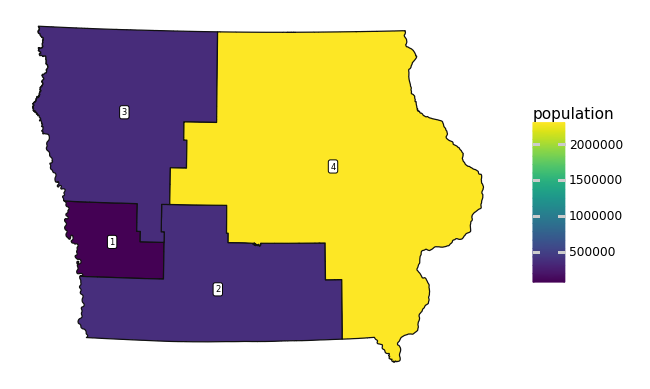


Iteration 2. The county id to move is 36.
[133122, 412348, 403501, 2241398] 

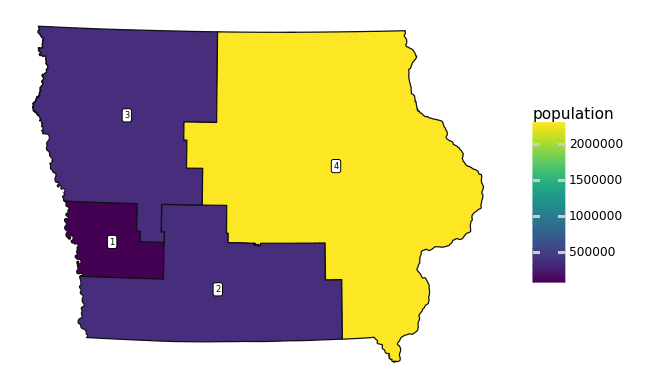


Iteration 3. The county id to move is 93.
[133122, 412348, 440500, 2204399] 

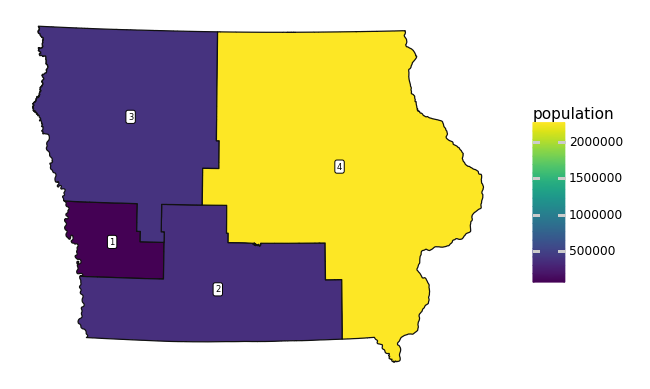


Iteration 4. The county id to move is 76.
[133122, 904749, 440500, 1711998] 

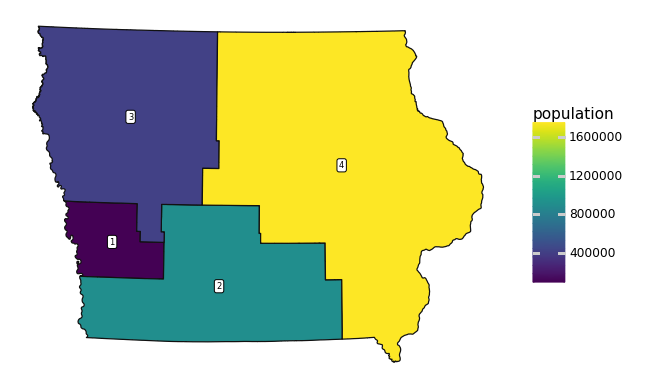


Iteration 5. The county id to move is 94.
[133122, 904749, 451179, 1701319] 

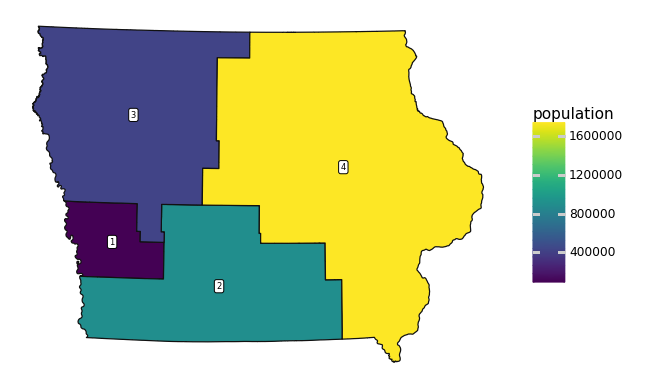


Iteration 6. The county id to move is 40.
[133122, 904749, 461974, 1690524] 

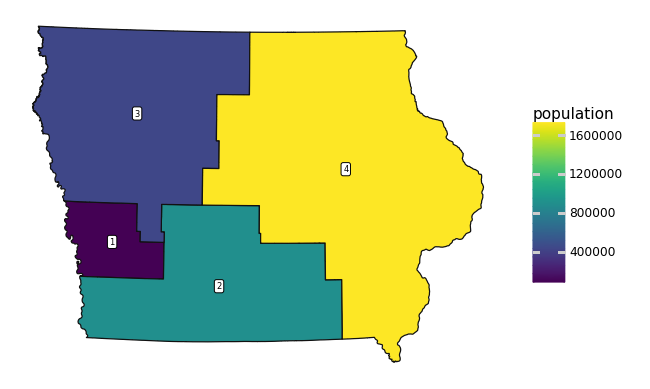


Iteration 7. The county id to move is 98.
[133122, 904749, 474917, 1677581] 

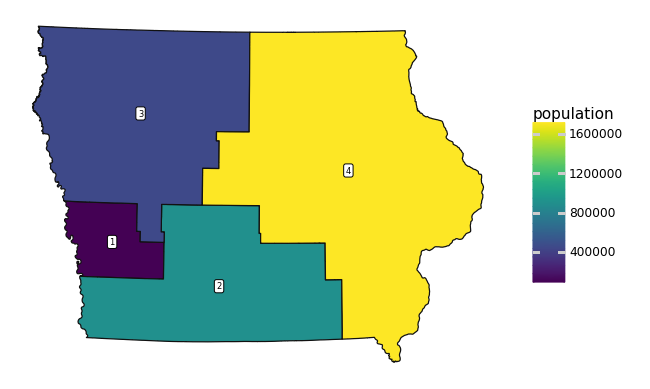


Iteration 8. The county id to move is 7.
[133122, 904749, 501632, 1650866] 

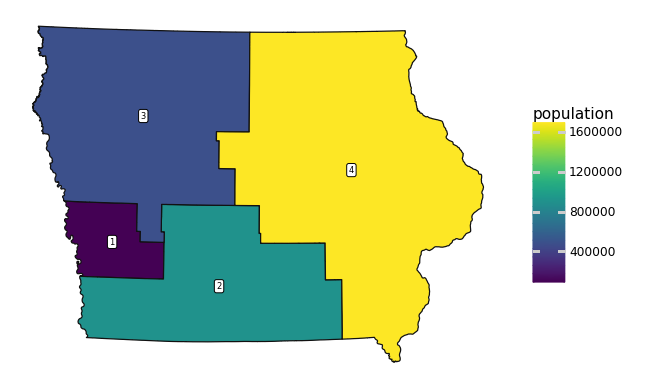


Iteration 9. The county id to move is 39.
[133122, 904749, 516671, 1635827] 

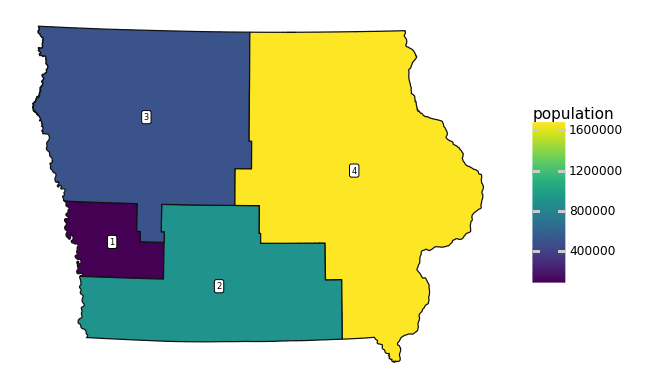


Iteration 10. The county id to move is 97.
[133122, 904749, 524114, 1628384] 

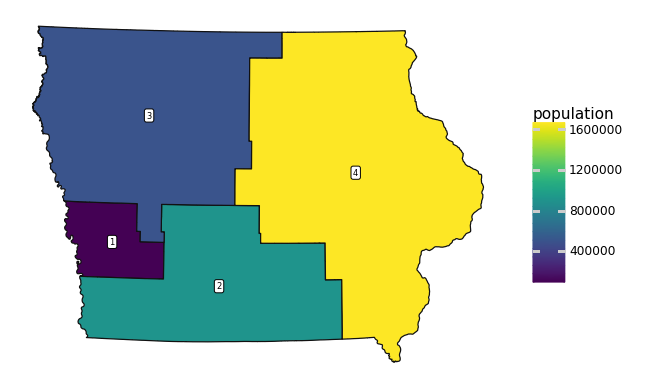


Iteration 11. The county id to move is 16.
[133122, 904749, 567241, 1585257] 

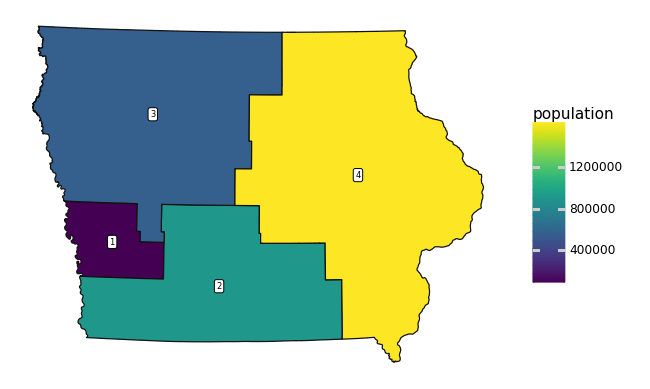


Iteration 12. The county id to move is 34.
[133122, 904749, 577260, 1575238] 

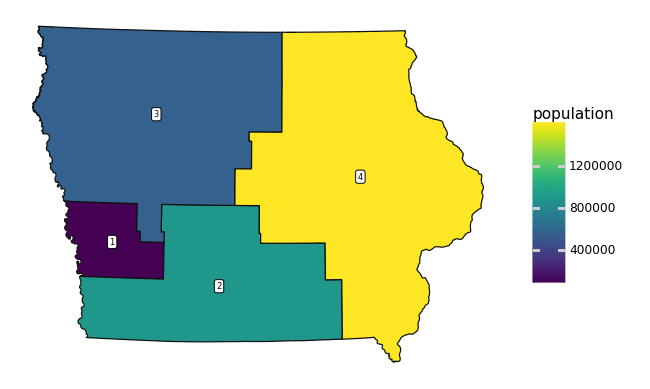


Iteration 13. The county id to move is 84.
[133122, 904749, 675797, 1476701] 

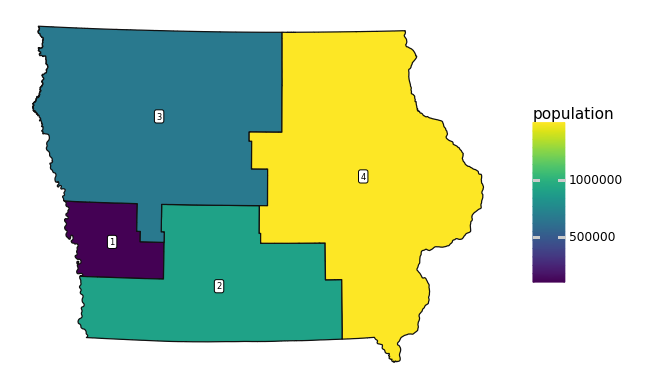


Iteration 14. The county id to move is 41.
[133122, 904749, 692675, 1459823] 

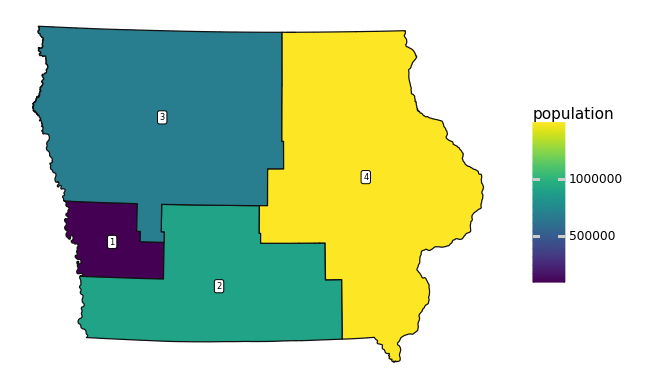


Iteration 15. The county id to move is 64.
[147606, 890265, 692675, 1459823] 

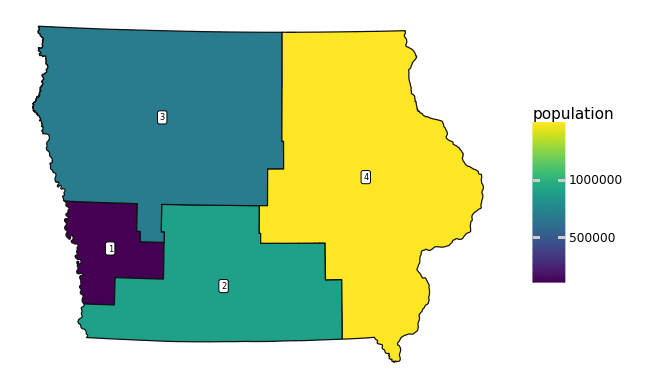


Iteration 16. The county id to move is 65.
[147606, 890265, 703240, 1449258] 

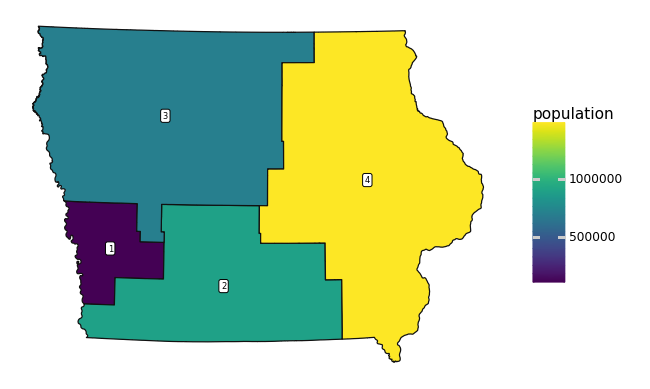


Iteration 17. The county id to move is 33.
[147606, 890265, 718867, 1433631] 

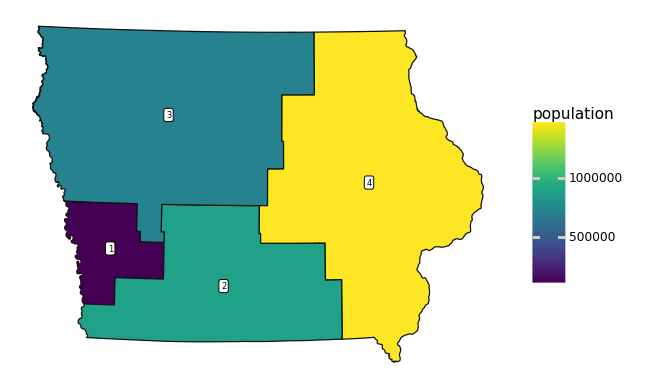


Iteration 18. The county id to move is 35.
[154211, 883660, 718867, 1433631] 

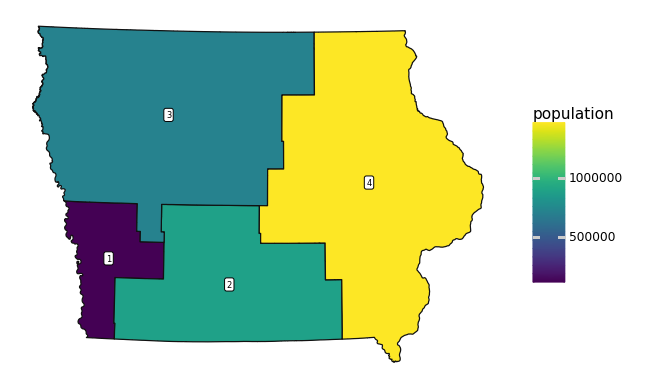


Iteration 19. The county id to move is 68.
[164541, 873330, 718867, 1433631] 

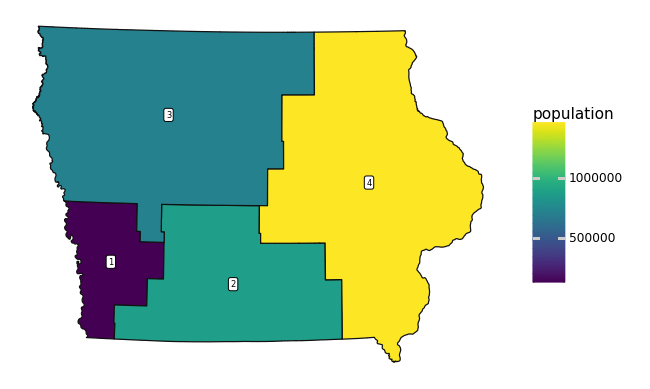


Iteration 20. The county id to move is 11.
[164541, 873330, 733201, 1419297] 

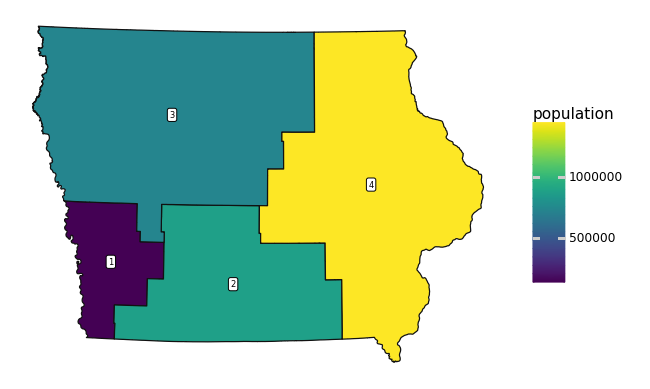


Iteration 21. The county id to move is 72.
[179752, 858119, 733201, 1419297] 

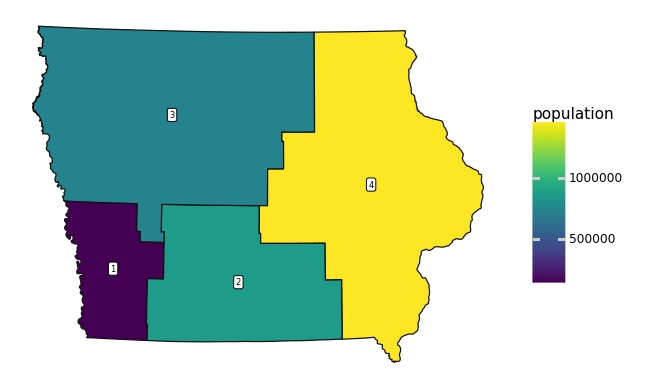


Iteration 22. The county id to move is 44.
[179752, 858119, 742670, 1409828] 

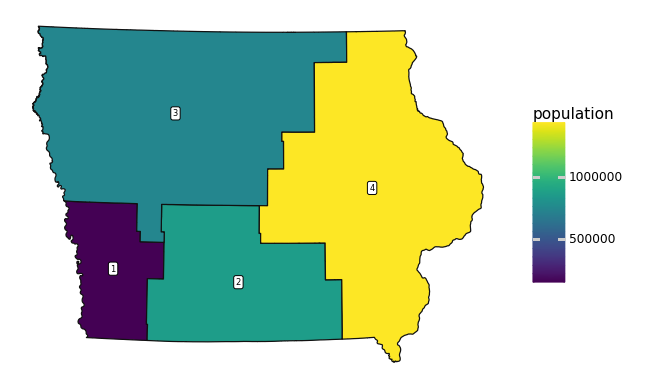


Iteration 23. The county id to move is 1.
[183456, 854415, 742670, 1409828] 

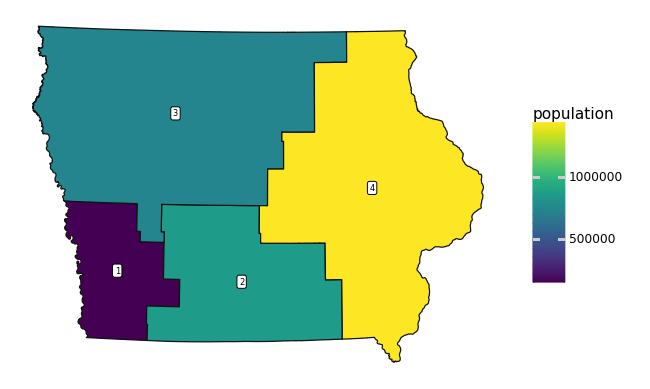


Iteration 24. The county id to move is 86.
[189352, 848519, 742670, 1409828] 

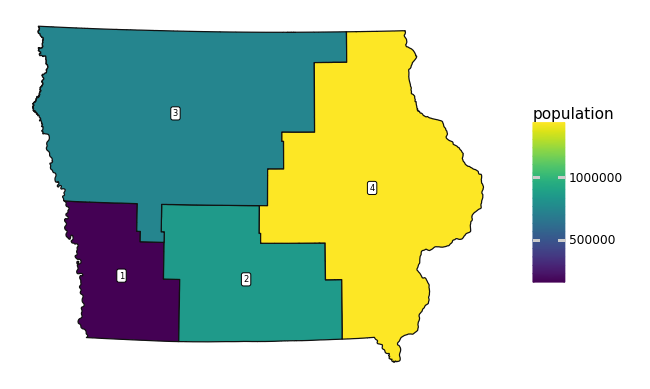


Iteration 25. The county id to move is 63.
[189352, 848519, 782775, 1369723] 

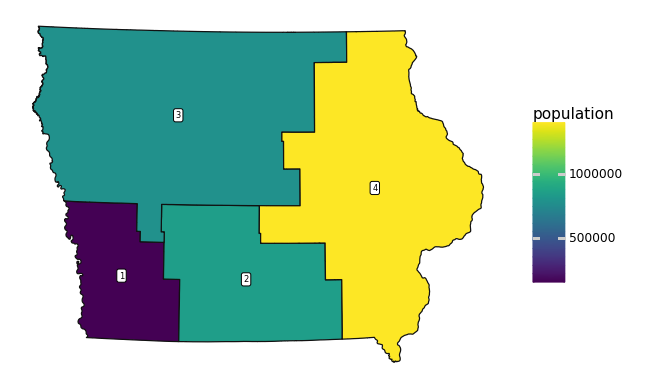


Iteration 26. The county id to move is 38.
[199975, 837896, 782775, 1369723] 

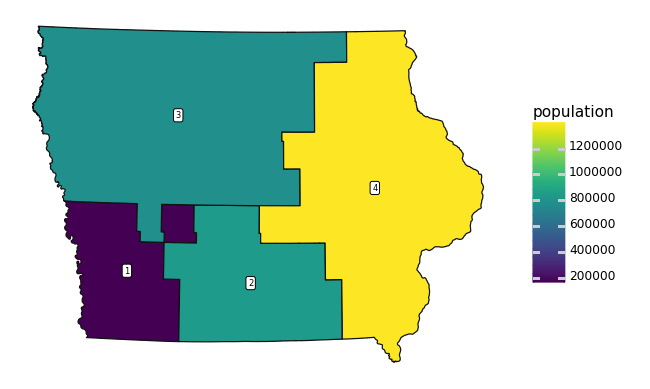


Iteration 27. The county id to move is 0.
[207471, 830400, 782775, 1369723] 

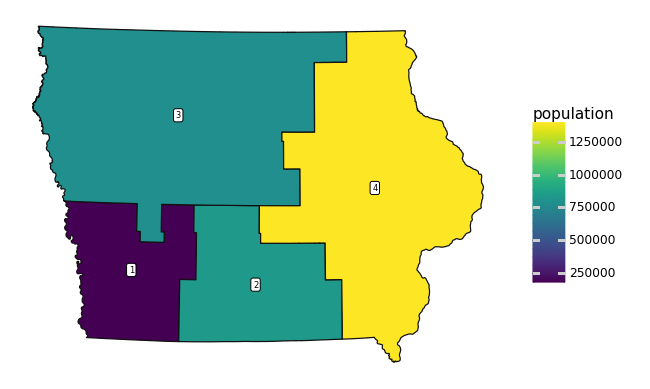


Iteration 28. The county id to move is 87.
[219609, 818262, 782775, 1369723] 

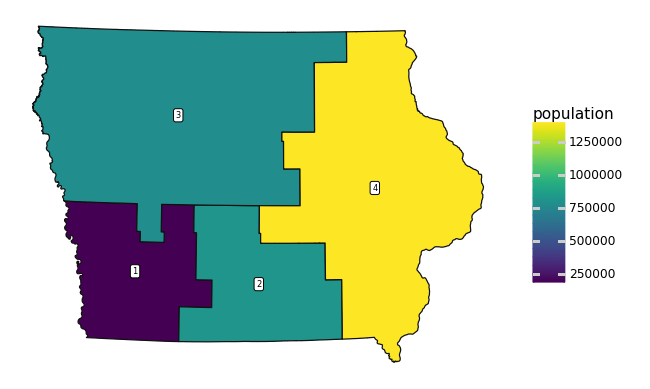


Iteration 29. The county id to move is 79.
[224272, 813599, 782775, 1369723] 

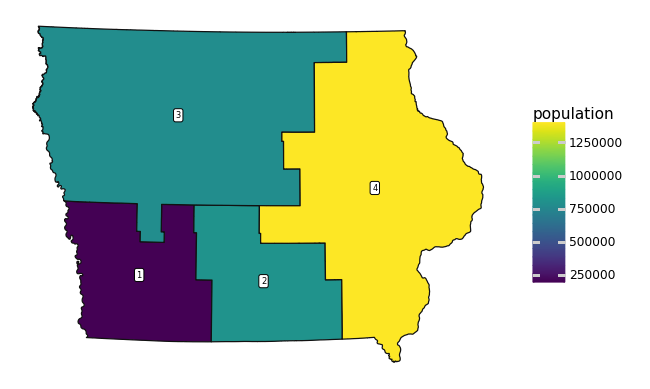


Iteration 30. The county id to move is 24.
[323950, 713921, 782775, 1369723] 

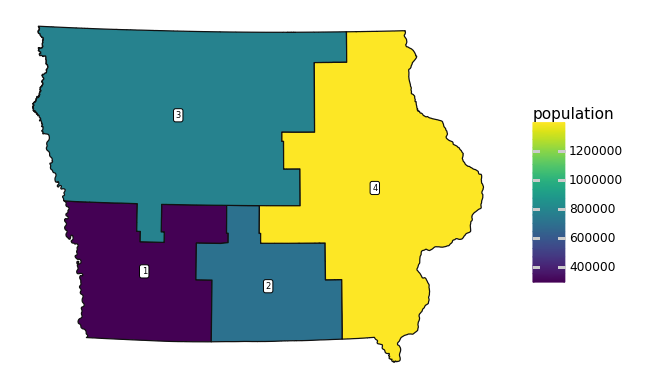


Iteration 31. The county id to move is 49.
[323950, 751734, 782775, 1331910] 

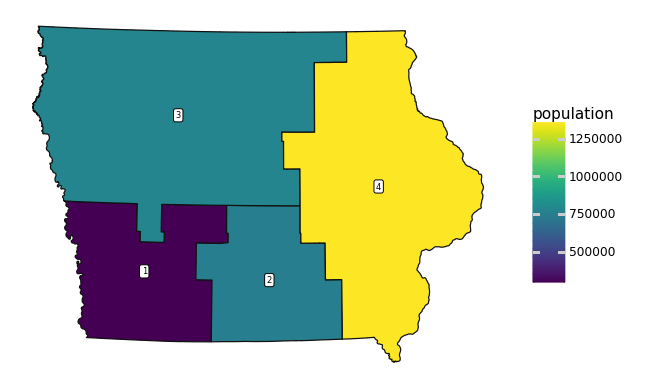


Iteration 32. The county id to move is 88.
[323950, 758937, 782775, 1324707] 

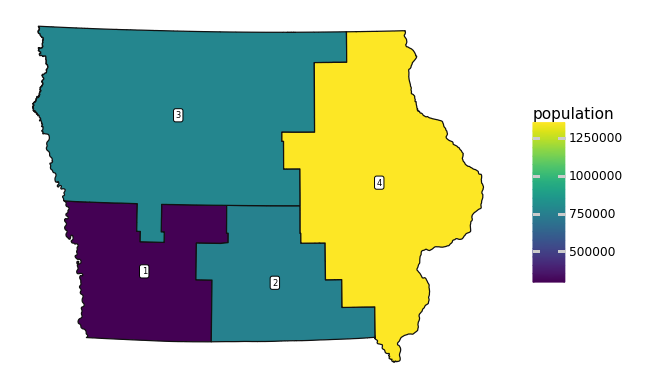


Iteration 33. The county id to move is 50.
[323950, 774600, 782775, 1309044] 

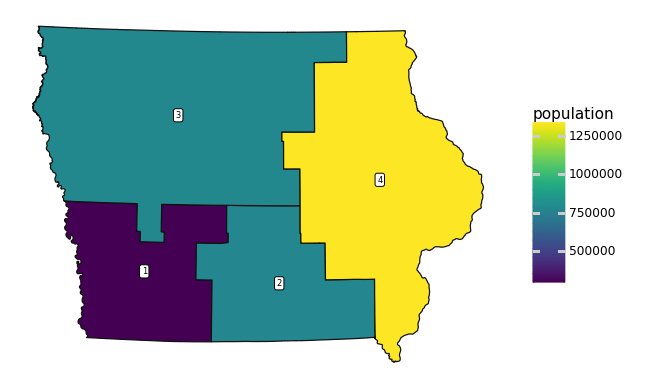


Iteration 34. The county id to move is 53.
[323950, 784633, 782775, 1299011] 

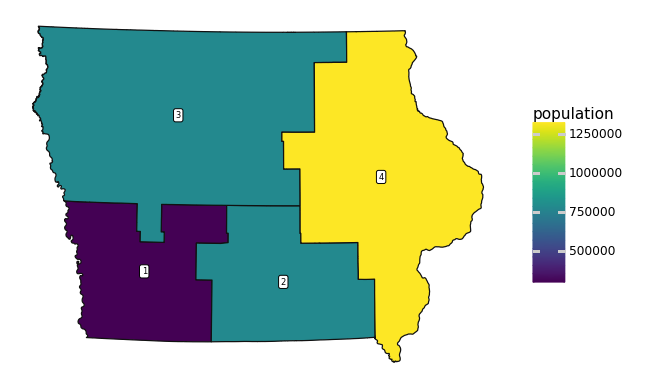


Iteration 35. The county id to move is 37.
[323950, 784633, 795104, 1286682] 

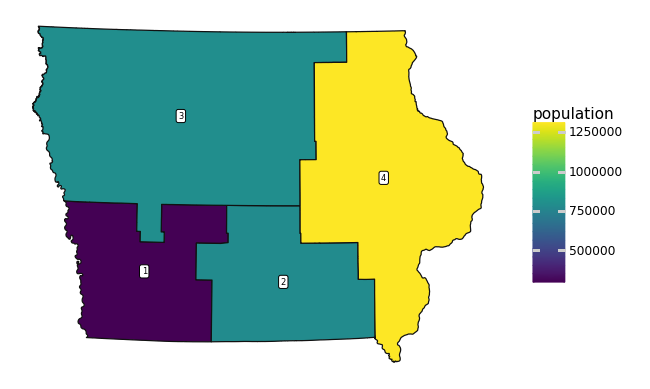


Iteration 36. The county id to move is 55.
[323950, 818188, 795104, 1253127] 

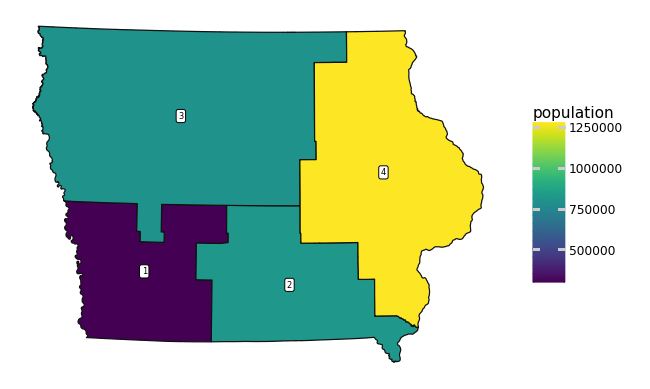


Iteration 37. The county id to move is 60.
[340498, 801640, 795104, 1253127] 

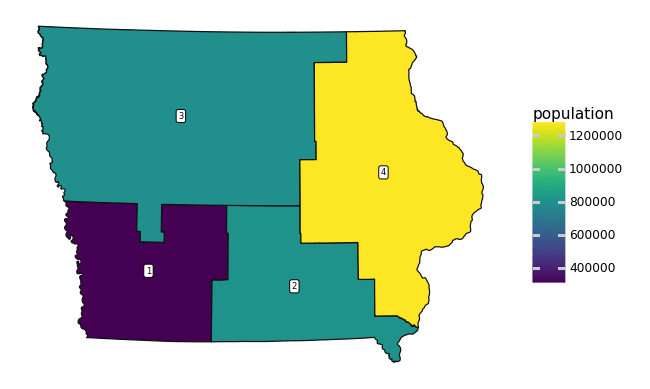


Iteration 38. The county id to move is 19.
[350246, 791892, 795104, 1253127] 

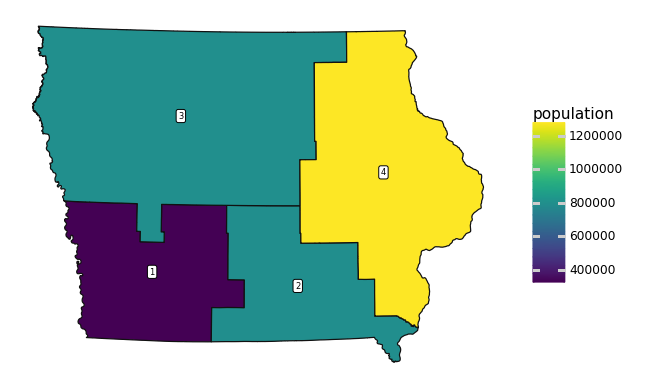


Iteration 39. The county id to move is 78.
[350246, 810554, 795104, 1234465] 

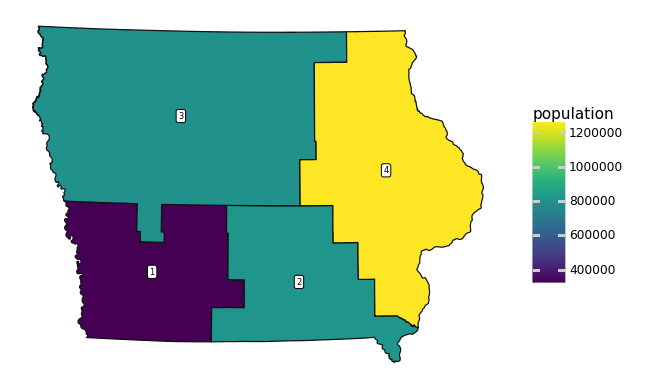


Iteration 40. The county id to move is 26.
[357891, 802909, 795104, 1234465] 

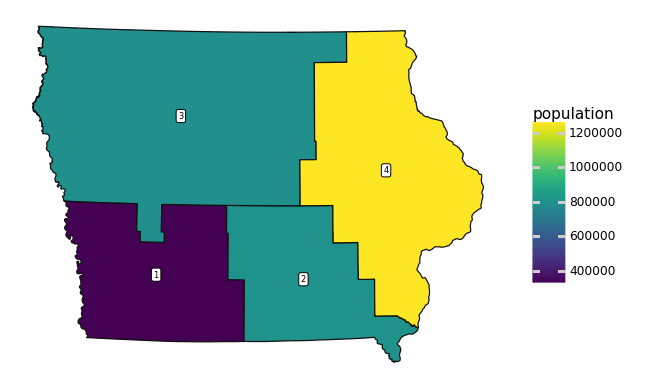


Iteration 41. The county id to move is 90.
[410294, 750506, 795104, 1234465] 

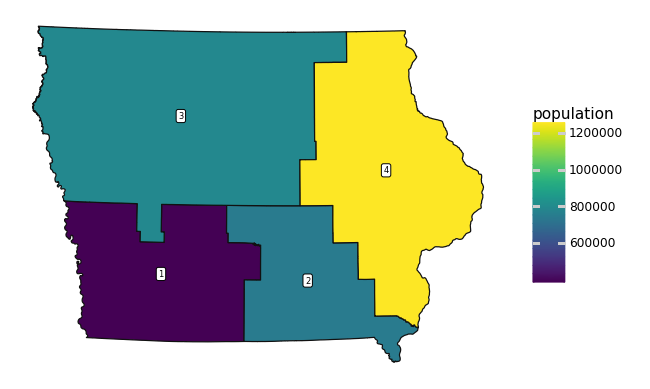


Iteration 42. The county id to move is 43.
[410294, 770988, 795104, 1213983] 

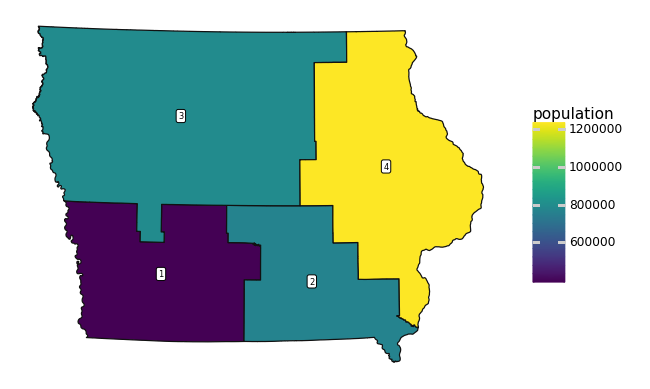


Iteration 43. The county id to move is 28.
[410294, 809898, 795104, 1175073] 

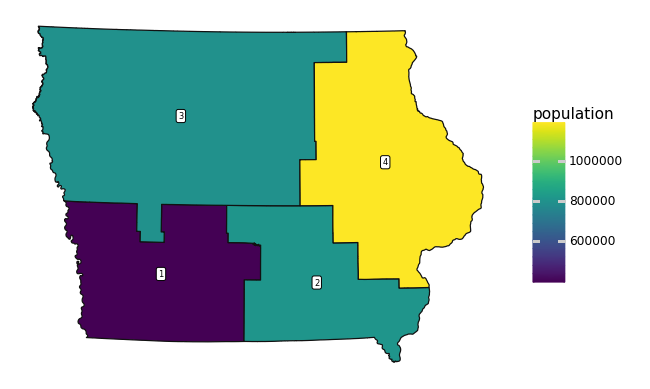


Iteration 44. The county id to move is 92.
[416791, 803401, 795104, 1175073] 

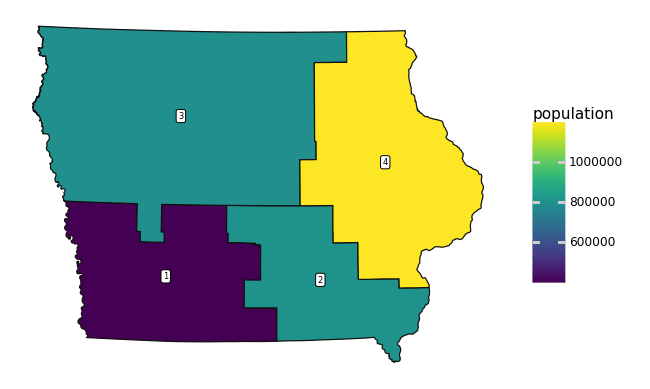


Iteration 45. The county id to move is 58.
[425425, 794767, 795104, 1175073] 

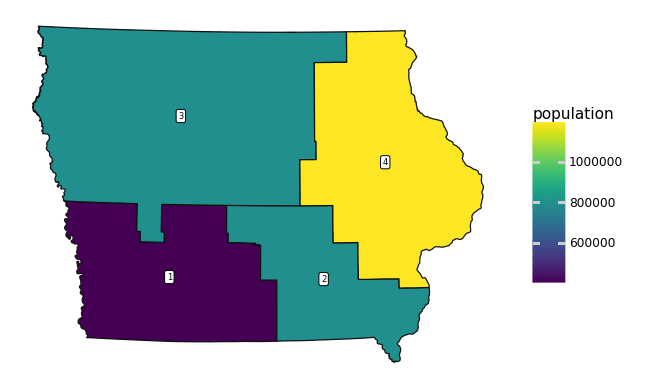


Iteration 46. The county id to move is 91.
[425425, 817332, 795104, 1152508] 

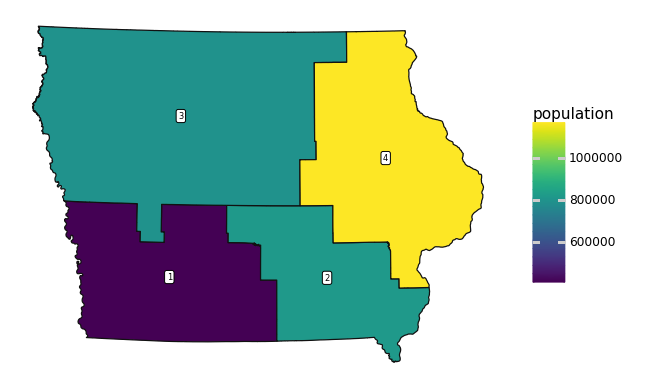


Iteration 47. The county id to move is 62.
[458839, 783918, 795104, 1152508] 

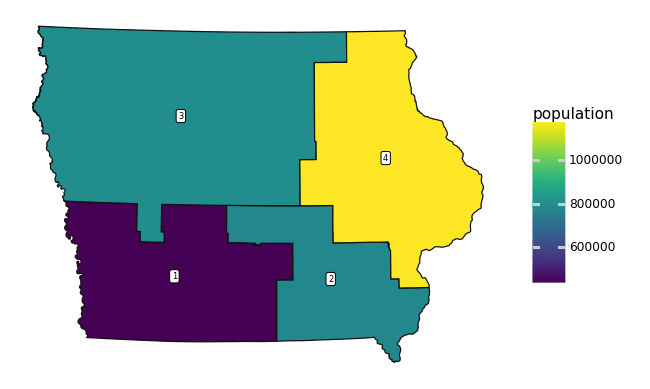


Iteration 48. The county id to move is 57.
[458839, 794755, 795104, 1141671] 

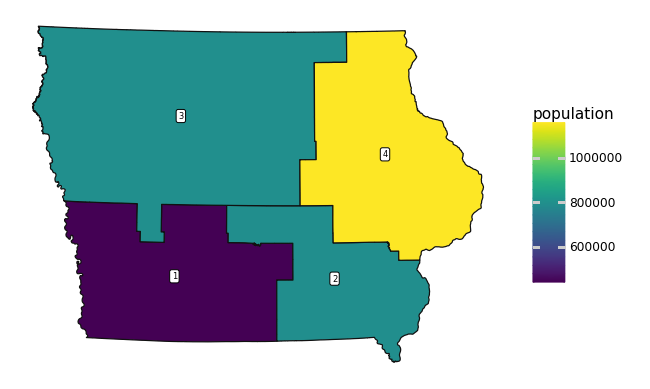


Iteration 49. The county id to move is 47.
[458839, 811417, 795104, 1125009] 

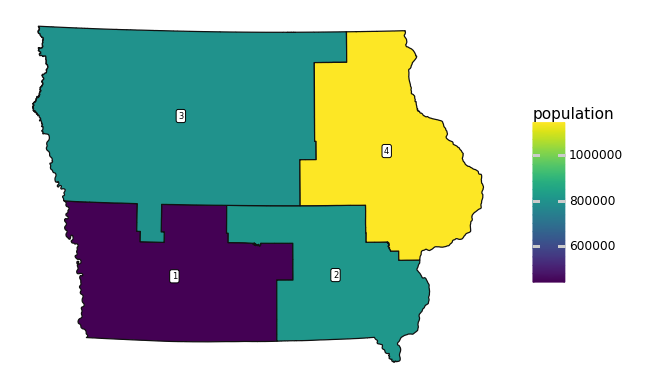


Iteration 50. The county id to move is 49.
[496652, 773604, 795104, 1125009] 

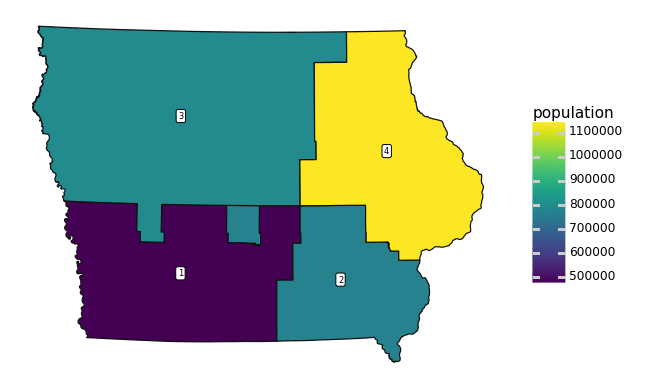


Iteration 51. The county id to move is 85.
[513787, 773604, 795104, 1107874] 

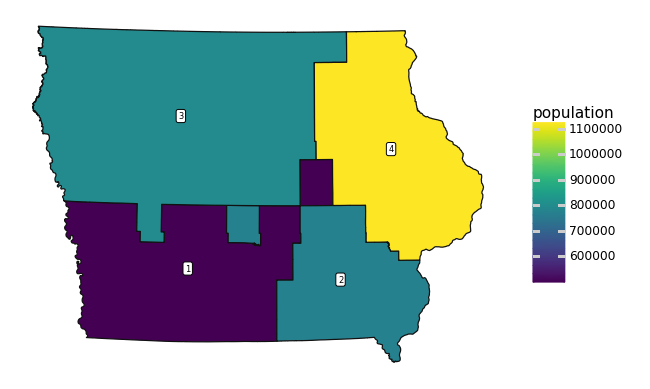


Iteration 52. The county id to move is 6.
[644931, 773604, 795104, 976730] 

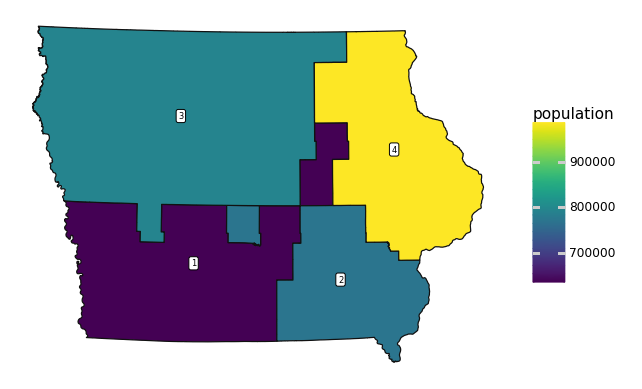


Iteration 53. The county id to move is 5.
[670506, 773604, 795104, 951155] 

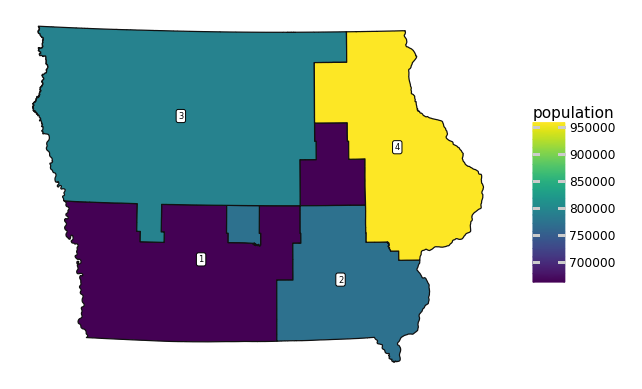


Iteration 54. The county id to move is 8.
[695494, 773604, 795104, 926167] 

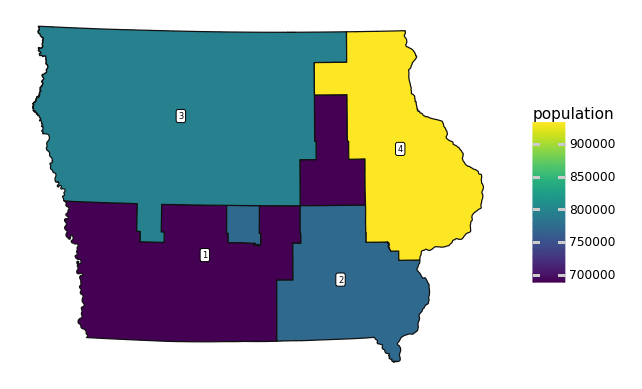


Iteration 55. The county id to move is 18.
[707506, 773604, 795104, 914155] 

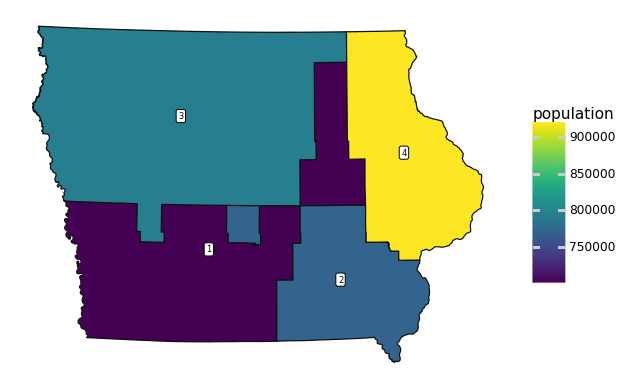


Iteration 56. The county id to move is 95.
[727576, 773604, 795104, 894085] 

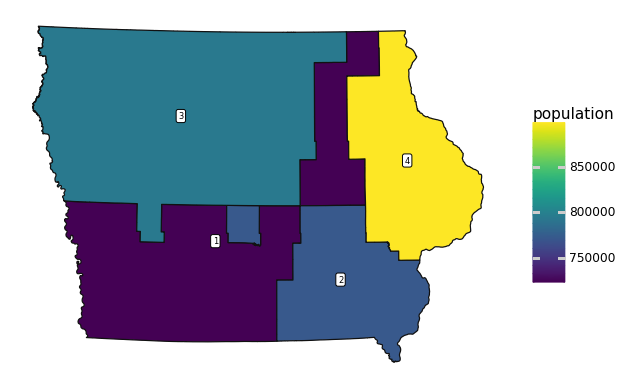


Iteration 57. The county id to move is 32.
[747085, 773604, 795104, 874576] 

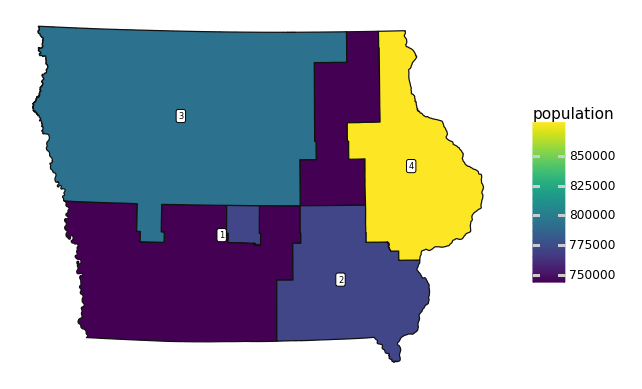


Iteration 58. The county id to move is 9.
[767650, 773604, 795104, 854011] 

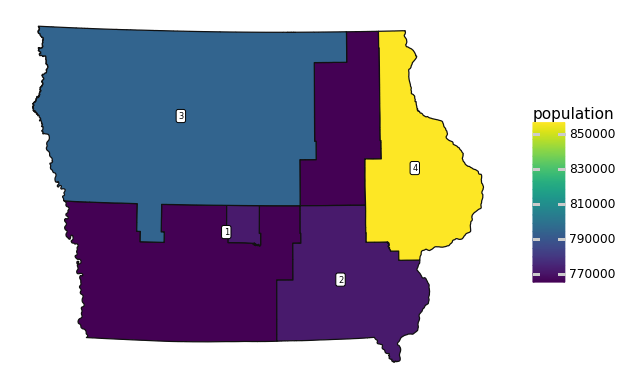


Iteration 59. The county id to move is 2.
[781711, 773604, 795104, 839950] 

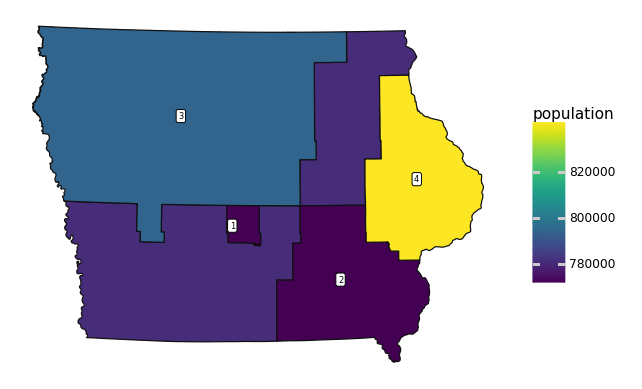


Iteration 60. The county id to move is 69.
[781711, 816839, 795104, 796715] 

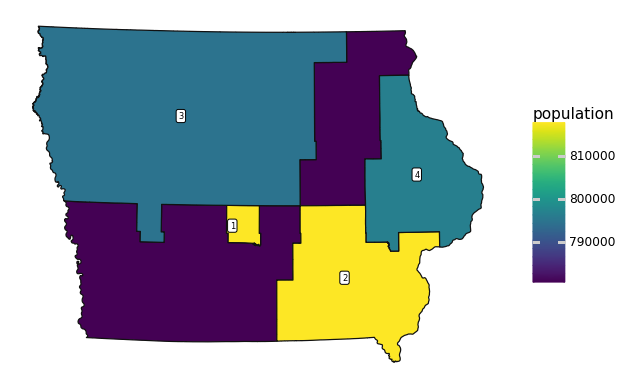


Iteration 61. The county id to move is 78.
[800373, 798177, 795104, 796715] 

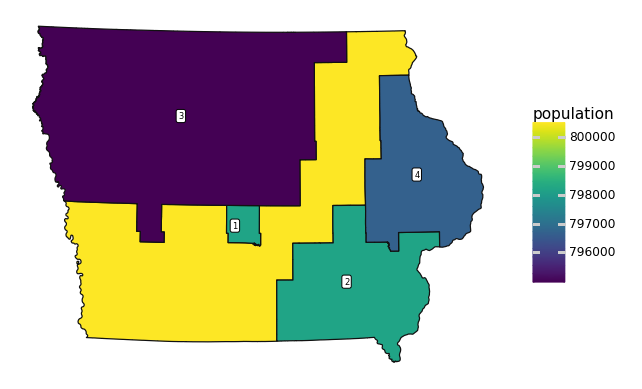

In [28]:
for k in range(70):

    # Making separate geodataframes for each district (one district/attribute in each).
    list_of_districts=[]
    for i in range(4):
        list_of_districts.append(shapef_ia_redist.iloc[[i]].reset_index(drop=True))

    #the identity overlay takes district n and splits it up by all counties
    # which fall inside it (from main, un-districted shapefile)
    #keep_geom_type=True   discards boundary points and lines from counties which only border the district
    #resulting dataframe columns: _1 stuff comes from parent (whole district)
    #                             _2 stuff comes from specific county
    list_of_counties=[]
    for i in range(4):
        list_of_counties.append(list_of_districts[i].overlay(shapef_counties_for_realloc,how='identity',keep_geom_type=True))

    #this records the district number each county is assigned to in the first pass
    shapef_counties_for_realloc['DISTRICT']=''
    for i in range(99):
        for j in range(4):
            # if i<j:
            if shapef_counties_for_realloc.iloc[i]['COUNTYFP10'] in list_of_counties[j]['COUNTYFP10'].tolist():
                shapef_counties_for_realloc.loc[i,'DISTRICT']=j+1
    # shapef_counties_for_realloc


    bigdist_movable=border_counties_fun(shapef_ia_redist, list_of_districts, list_of_counties)[0]
    pop_limit_switch=border_counties_fun(shapef_ia_redist, list_of_districts, list_of_counties)[1]
    new_district = border_counties_fun(shapef_ia_redist, list_of_districts, list_of_counties)[2] + 1
    # bigdist_movable
    switches_threshold=switch_threshold_fun(bigdist_movable)


    # What county should be switched? Humboldt! (FIPS 091/id 45)
    movingcounty_index=switch_func(bigdist_movable, switches_threshold,pop_limit_switch)
    # print(movingcounty_index)

    print("Iteration %d. The county id to move is %d." \
        % (k+1,            
            movingcounty_index
           ) )


    # Update 99 row dataframe:
    shapef_counties_for_realloc.loc[movingcounty_index,'DISTRICT'] = new_district
    shapef_counties_for_realloc.loc[movingcounty_index,'num_switches'] = shapef_counties_for_realloc.loc[movingcounty_index,'num_switches']+1

    # overwriting old 4 row geodataframe with the new version (dissolved based on updated district number) 
    shapef_ia_redist = dissolve_by_district(shapef_counties_for_realloc)

    print(shapef_ia_redist['population'].to_list(), map_merged_districts(shapef_ia_redist,'DISTRICT'))

    district_min=ideal_district_size_func(state_population, n_districts, .01)[0]
    district_max=ideal_district_size_func(state_population, n_districts, .01)[1]

    if shapef_ia_redist['population'].max() in range(district_min, district_max+1) and shapef_ia_redist['population'].min() in range(district_min, district_max+1):
        break



## Steps for next time (9/22):
1. Things we tried
    - switch_fun was modified to:
        - exclude population limit entirely. This resulted in 2 discontiguous districts. This took longer for district sizes to converge to desired population range.
        - increase population threshold to .7 of the population difference (bumping up from 1/2) in tandem with 2/3 range of num_switches
        - switches_threshold was modified from .5 to 2/3 of the switches range.
    -  With population threshold at .5, the loop broke at iteration 59
        - With population threshold at .7, ideal district sizes were attained at iteration 61, but yielded 1 discontiguous district where Polk county was isolated.
        - When the southeast district became discontiguous, the algorithm skipped counties 03 and 67 (also Polk)
2. To investigate:
    - determine why 03 and 67 weren't moved
    - figure out how to export district maps from for loop into separate file as the for loop updates
    - look into gpd documentation to see how to address kitty corners:
        - do we add a minimum adjacency threshold (ie must share a border at least X miles long)
        - Perhaps add in criteria after moving_index is identified
            -check if the move will yield discontiguous districts. If yes, discard option and move to next choice. If not, move that county.
        - If there are no good counties to move between a pair of districts, move to the next pair of districts

In [43]:
shapef_counties_for_realloc.loc[shapef_counties_for_realloc['num_switches']>1]

,COUNTYFP10,NAME10,geometry,population,county_id,xcentr_lon,ycentr_lat,county_id_string,temp_district,num_switches,DISTRICT
49,099,Jasper,"POLYGON ((519437.635 4615176.061, 519437.991 4...",37813,49,495526.676875,4.614916e+06,49,49,2,1
78,157,Poweshiek,"POLYGON ((548502.841 4634675.905, 548944.218 4...",18662,78,538993.297726,4.615060e+06,78,78,2,1


In [71]:
ideal_district_size_func(state_population, n_districts, .1)

(717833, 877351)

In [70]:
shapef_ia_redist

,geometry,population,xcentr_lon,ycentr_lat,DISTRICT
0,"MULTIPOLYGON (((413996.789 4491953.713, 413922...",747085,426357.727861,4.603750e+06,1
1,"MULTIPOLYGON (((491768.136 4518326.458, 491768...",773604,567344.210080,4.557124e+06,2
2,"POLYGON ((325806.753 4617405.526, 325806.847 4...",795104,377968.335208,4.728567e+06,3
3,"POLYGON ((634870.057 4587002.443, 634846.066 4...",874576,651135.773646,4.676086e+06,4


In [126]:
shapef_counties_for_realloc.loc[shapef_counties_for_realloc['county_id']==movingcounty_index]

,COUNTYFP10,NAME10,geometry,population,county_id,xcentr_lon,ycentr_lat,county_id_string,temp_district,num_switches,DISTRICT
36,073,Greene,"POLYGON ((364955.036 4645564.668, 364958.141 4...",8771,36,384380.986817,4.654735e+06,36,36,1,3


In [121]:
# new 4 row geodataframe with humboldt having moved from district 4 to district 3
shapef_newdissolved_temp = dissolve_by_district(shapef_counties_for_realloc)
shapef_newdissolved_temp

,geometry,population,xcentr_lon,ycentr_lat,DISTRICT
0,"POLYGON ((347722.464 4557927.937, 347713.169 4...",133122,296454.715195,4.596624e+06,1
1,"POLYGON ((530640.900 4493402.478, 530528.621 4...",412348,421801.425712,4.546914e+06,2
2,"POLYGON ((325801.578 4617291.999, 325803.323 4...",394730,310917.307227,4.732490e+06,3
3,"POLYGON ((659475.197 4506757.653, 659405.803 4...",2250169,558428.607582,4.675692e+06,4


### visualizations

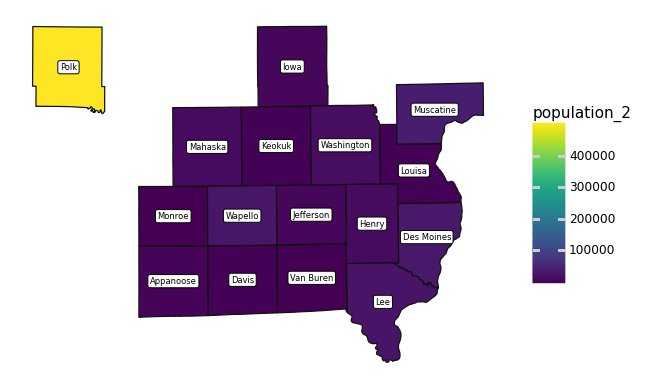

<ggplot: (365375230)>

In [46]:
#this gives an example of output of map_unmerged_districts
map_unmerged_districts(list_of_counties[1],'NAME10')

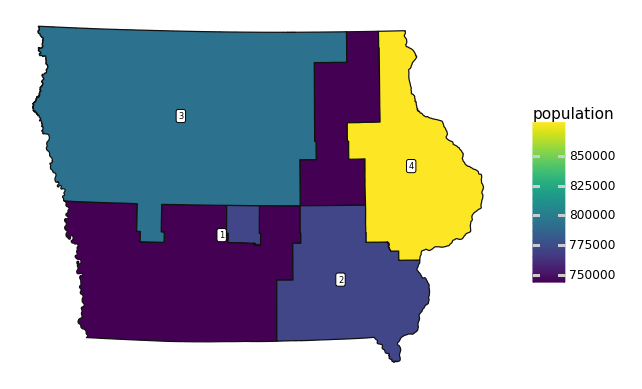

<ggplot: (366685178)>

In [72]:
map_merged_districts(shapef_ia_redist,'DISTRICT')

## Chen's algorithm for reallocation

From Chen's paper:

(3a) Among all pairs of districts that border one another, identify the pair with the greatest disparity in district population. Within this pair,
let us denote the more populated district as $i$ and the less populated district as $j$.

(3b) Identify the set of all precincts currently within district $i$ that could be reassigned to district $j$ without violating the geographic contiguity of either district $i$ or $j$.

(3c) For each precinct $p$ satisfying the criterion in step 3b, define $D_p$ as precinct $p$’s geographic distance to the centroid of district $i$, minus
precinct $p$’s distance to the centroid of district $j$.

(3d) Among the set of precincts satisfying the criteria in step 3b, select the precinct, $p$, with the highest value of Dp . Reassign this precinct from
district $i$ to district $j$.